# Orfeo Toolbox (OTB) Tutorial - Image Processing

## Overview

Orfeo Toolbox (OTB) is a powerful open-source library for remote sensing image processing with approximately 230 algorithms covering edge detection, texture analysis, and image filtering. This tutorial demonstrates OTB's image processing capabilities applied to DEM data.

## What You'll Learn

This tutorial covers three image processing techniques: Edge Detection using the Sobel filter to identify terrain boundaries, Texture Analysis using Haralick features to characterize surface patterns, and Image Smoothing using Mean, Gaussian, and Anisotropic Diffusion filters for noise reduction.

## Prerequisites

This notebook requires the `watershed_dem.tif` file created by running Notebook 03 (Watershed Delineation). The configuration file `watershed_analysis.json` from Notebook 01 must also be present.

## Setup: Load Configuration and Imports

This cell loads the configuration and imports required libraries. It also prepares the DEM by reprojecting to UTM (EPSG:32645) and creating a cleaned version with NoData values properly masked for OTB processing.

In [14]:
import json
import os
import subprocess
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load configuration
with open('watershed_analysis.json', 'r') as f:
    config = json.load(f)

# Create output directories
os.makedirs(config["temp_dir"], exist_ok=True)
os.makedirs(config["output_dir"], exist_ok=True)

print("Configuration loaded")
print(f"DEM: {config['dem_path']}")
print(f"Output directory: {config['output_dir']}")


# Prepare cleaned and projected DEM

watershed_dem = config["dem_path"]
cleaned_dem_saga = os.path.join(config['output_dir'], 'watershed_dem_clean_saga.tif')
watershed_dem_utm = os.path.join(config['output_dir'], 'watershed_dem_utm.tif')

# Step 1: Reproject to UTM meters (EPSG:32645) if not done
if not os.path.exists(watershed_dem_utm):
    subprocess.run([
        "gdalwarp",
        "-t_srs", "EPSG:32645",
        "-r", "bilinear",
        "-of", "GTiff",
        watershed_dem,
        watershed_dem_utm
    ], check=True)
    print(f"DEM reprojected to UTM: {watershed_dem_utm}")

# Step 2: Create cleaned DEM for SAGA (mask -9999 values) if not done
if not os.path.exists(cleaned_dem_saga):
    with rasterio.open(watershed_dem_utm) as src:
        dem = src.read(1).astype(float)
        profile = src.profile
        dem[dem == -9999] = np.nan
        profile.update(dtype=rasterio.float32, nodata=np.nan)
        
        with rasterio.open(cleaned_dem_saga, 'w', **profile) as dst:
            dst.write(dem.astype(rasterio.float32), 1)
    print(f"Cleaned DEM created for SAGA: {cleaned_dem_saga}")


Configuration loaded
DEM: clipped_dem.tif
Output directory: results


## Helper Functions for OTB

This cell defines helper functions for OTB processing:

**`run_otb_tool(app_name, parameters)`**: Executes OTB applications via the command line. OTB tools are accessed using the `otbcli_` prefix followed by the application name.

**`visualize_raster(filepath, title, cmap)`**: Creates matplotlib visualizations with percentile clipping to handle outliers in the data.

**`compute_statistics(filepath)`**: Calculates min, max, mean, and standard deviation for raster data.

In [19]:
def run_otb_tool(app_name, parameters, verbose=False):
    """
    Execute an OTB application
    """
    otb_app = os.path.join(config['otb_bin'], f'otbcli_{app_name}')
    cmd = [otb_app]
    
    for key, value in parameters.items():
        cmd.append(f'-{key}')
        cmd.append(str(value))
    
    if verbose:
        print(f"Running: {' '.join(cmd)}")
    
    result = subprocess.run(cmd, capture_output=True, text=True)
    
    if result.returncode != 0:
        print(f"Error running OTB application:")
        print(result.stderr)
        raise Exception(f"OTB application {app_name} failed")
    
    if verbose:
        print("Complete")
    
    return result


def visualize_raster(file_path, title, cmap='viridis', figsize=(10, 8), percentile=(2, 98)):
    """
    Visualize a raster file - improved version
    """
    with rasterio.open(file_path) as src:
        data = src.read(1, masked=True)
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    
    # Use percentiles for better visualization
    valid_data = data[~data.mask] if hasattr(data, 'mask') else data[~np.isnan(data)]
    if len(valid_data) > 0:
        vmin, vmax = np.percentile(valid_data, percentile)
    else:
        vmin, vmax = np.nanmin(data), np.nanmax(data)
    
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(data, cmap=cmap, extent=extent, aspect='equal', vmin=vmin, vmax=vmax)
    ax.set_title(title, fontsize=13, fontweight='bold', pad=12)
    ax.set_xlabel('Easting (m)', fontsize=10)
    ax.set_ylabel('Northing (m)', fontsize=10)
    
    ax.ticklabel_format(style='plain', useOffset=False)
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right', fontsize=9)
    plt.setp(ax.get_yticklabels(), fontsize=9)
    
    cbar = plt.colorbar(im, ax=ax, shrink=0.5, pad=0.03)
    cbar.ax.tick_params(labelsize=9)
    
    plt.tight_layout()
    plt.show()
    plt.close()


def compute_statistics(file_path):
    """
    Compute basic statistics for a raster file
    """
    with rasterio.open(file_path) as src:
        data = src.read(1, masked=True)
    
    valid_data = data[~data.mask] if hasattr(data, 'mask') else data[~np.isnan(data)]
    
    return {
        'min': np.min(valid_data) if len(valid_data) > 0 else np.nan,
        'max': np.max(valid_data) if len(valid_data) > 0 else np.nan,
        'mean': np.mean(valid_data) if len(valid_data) > 0 else np.nan,
        'std': np.std(valid_data) if len(valid_data) > 0 else np.nan,
        'median': np.median(valid_data) if len(valid_data) > 0 else np.nan
    }


print("Helper functions loaded")

Helper functions loaded


## Visualize Original DEM

This cell displays the cleaned, reprojected DEM that will be used as input for OTB processing. The visualization helps establish a baseline for comparing the effects of different image processing operations.

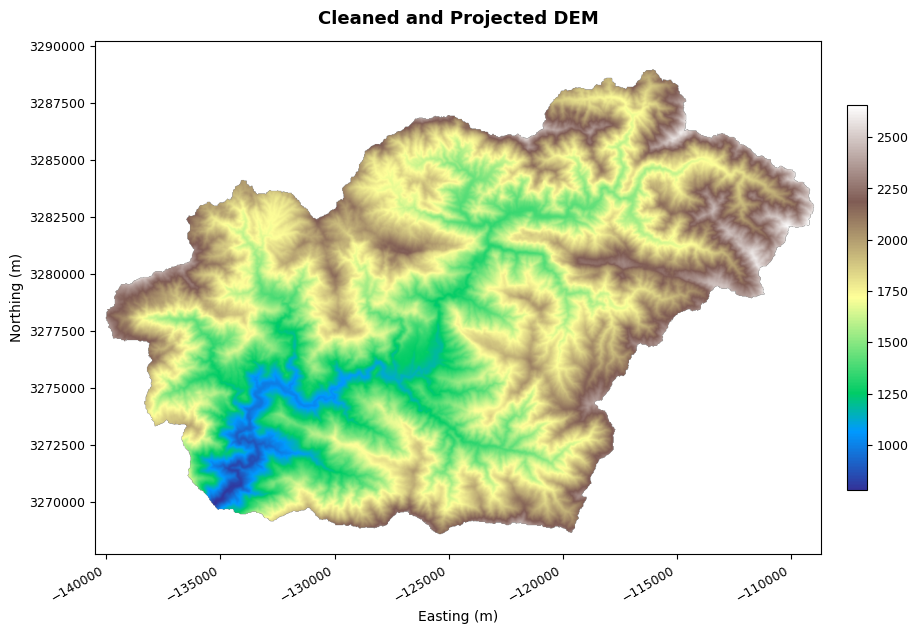

In [20]:
# Use the cleaned, projected DEM for visualization
cleaned_dem_saga = os.path.join(config['output_dir'], 'watershed_dem_clean_saga.tif')

visualize_raster(
    cleaned_dem_saga,
    title='Cleaned and Projected DEM',
    cmap='terrain',
    percentile=(0, 100)
)

## 1. Edge Detection

Edge detection identifies boundaries and discontinuities by detecting areas of rapid intensity change. In DEMs, edges correspond to ridge lines, valley bottoms, breaks in slope, and terrain feature boundaries.

The Sobel edge detector uses gradient operators to detect edges. It is fast and efficient, making it good for identifying major terrain features. Applications include geomorphological feature extraction, fault line detection, and drainage network delineation.

**OTB Application**: `otbcli_EdgeExtraction` with type=sobel

In [21]:
print("Applying Sobel Edge Detection...\n")

sobel_edges = os.path.join(config['output_dir'], 'otb_sobel_edges.tif')

# Use cleaned, projected DEM for correct edge detection
cleaned_dem = os.path.join(config['output_dir'], 'watershed_dem_clean_saga.tif')
if not os.path.exists(cleaned_dem):
    raise FileNotFoundError("Cleaned DEM not found. Run the DEM preprocessing step first!")

# EDIT: force bash so otbenv.profile is sourced
cmd = (
    "source /opt/otb/otbenv.profile && "
    f"otbcli_EdgeExtraction -in {cleaned_dem} -filter sobel -out {sobel_edges}"
)

result = subprocess.run(
    ["bash", "-lc", cmd],
    capture_output=True,
    text=True
)

if result.returncode != 0:
    print("Error running OTB application:")
    print(result.stderr)
    raise Exception("OTB application EdgeExtraction failed")

print(f"Sobel edges saved to: {sobel_edges}")


Applying Sobel Edge Detection...

Sobel edges saved to: results/otb_sobel_edges.tif


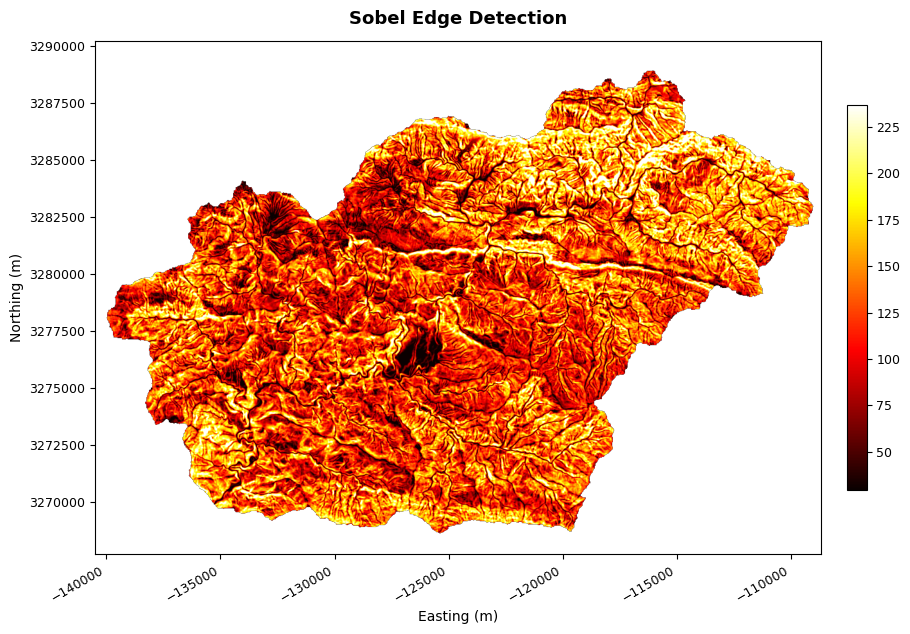

In [22]:
visualize_raster(
    sobel_edges,
    title='Sobel Edge Detection',
    cmap='hot',
    percentile=(2, 98)
)

### Interpreting Sobel Edges

In the edge detection output, bright areas with high values indicate strong edges corresponding to sharp elevation changes, ridges, and valleys. Dark areas with low values indicate smooth terrain with gradual elevation changes.

## 2. Texture Analysis - Haralick Features

Texture describes the spatial arrangement of pixel intensities. Haralick features are derived from the Gray-Level Co-occurrence Matrix (GLCM), which captures spatial relationships between pixel pairs.

Key Haralick features include Energy (uniformity of texture where high values indicate uniform areas), Entropy (randomness of texture where high values indicate random patterns), Correlation (linear dependency between pixel pairs indicating directional patterns), and Contrast (local intensity variation).

Applications include landform classification, terrain roughness characterization, and land cover mapping.

**OTB Application**: `otbcli_HaralickTextureExtraction`

In [23]:
print("Calculating Haralick Texture Features...\n")

haralick_output = os.path.join(config['output_dir'], 'otb_haralick_features.tif')

# Use cleaned, projected DEM for correct texture extraction
cleaned_dem = os.path.join(config['output_dir'], 'watershed_dem_clean_saga.tif')
if not os.path.exists(cleaned_dem):
    raise FileNotFoundError("Cleaned DEM not found. Run the DEM preprocessing step first!")

run_otb_tool(
    app_name='HaralickTextureExtraction',
    parameters={
        'in': cleaned_dem,
        'channel': 1,
        'texture': 'simple',
        'parameters.xrad': 3,
        'parameters.yrad': 3,
        'parameters.xoff': 1,
        'parameters.yoff': 1,
        'out': haralick_output
    }
)

print(f"Haralick features saved to: {haralick_output}")

Calculating Haralick Texture Features...

Haralick features saved to: results/otb_haralick_features.tif


Step 1: Rescaling DEM to 8-bit for texture analysis...
   Original DEM range: 781.1 - 2657.0 m
   Clipping to: 984.2 - 2427.3 m (1st-99th percentile)
   Rescaled DEM saved to: results/dem_rescaled_8bit.tif

Step 2: Calculating Haralick Texture Features...
   Haralick features saved to: results/otb_haralick_features.tif

Step 3: Visualizing Haralick texture features...

Number of Haralick feature bands: 8


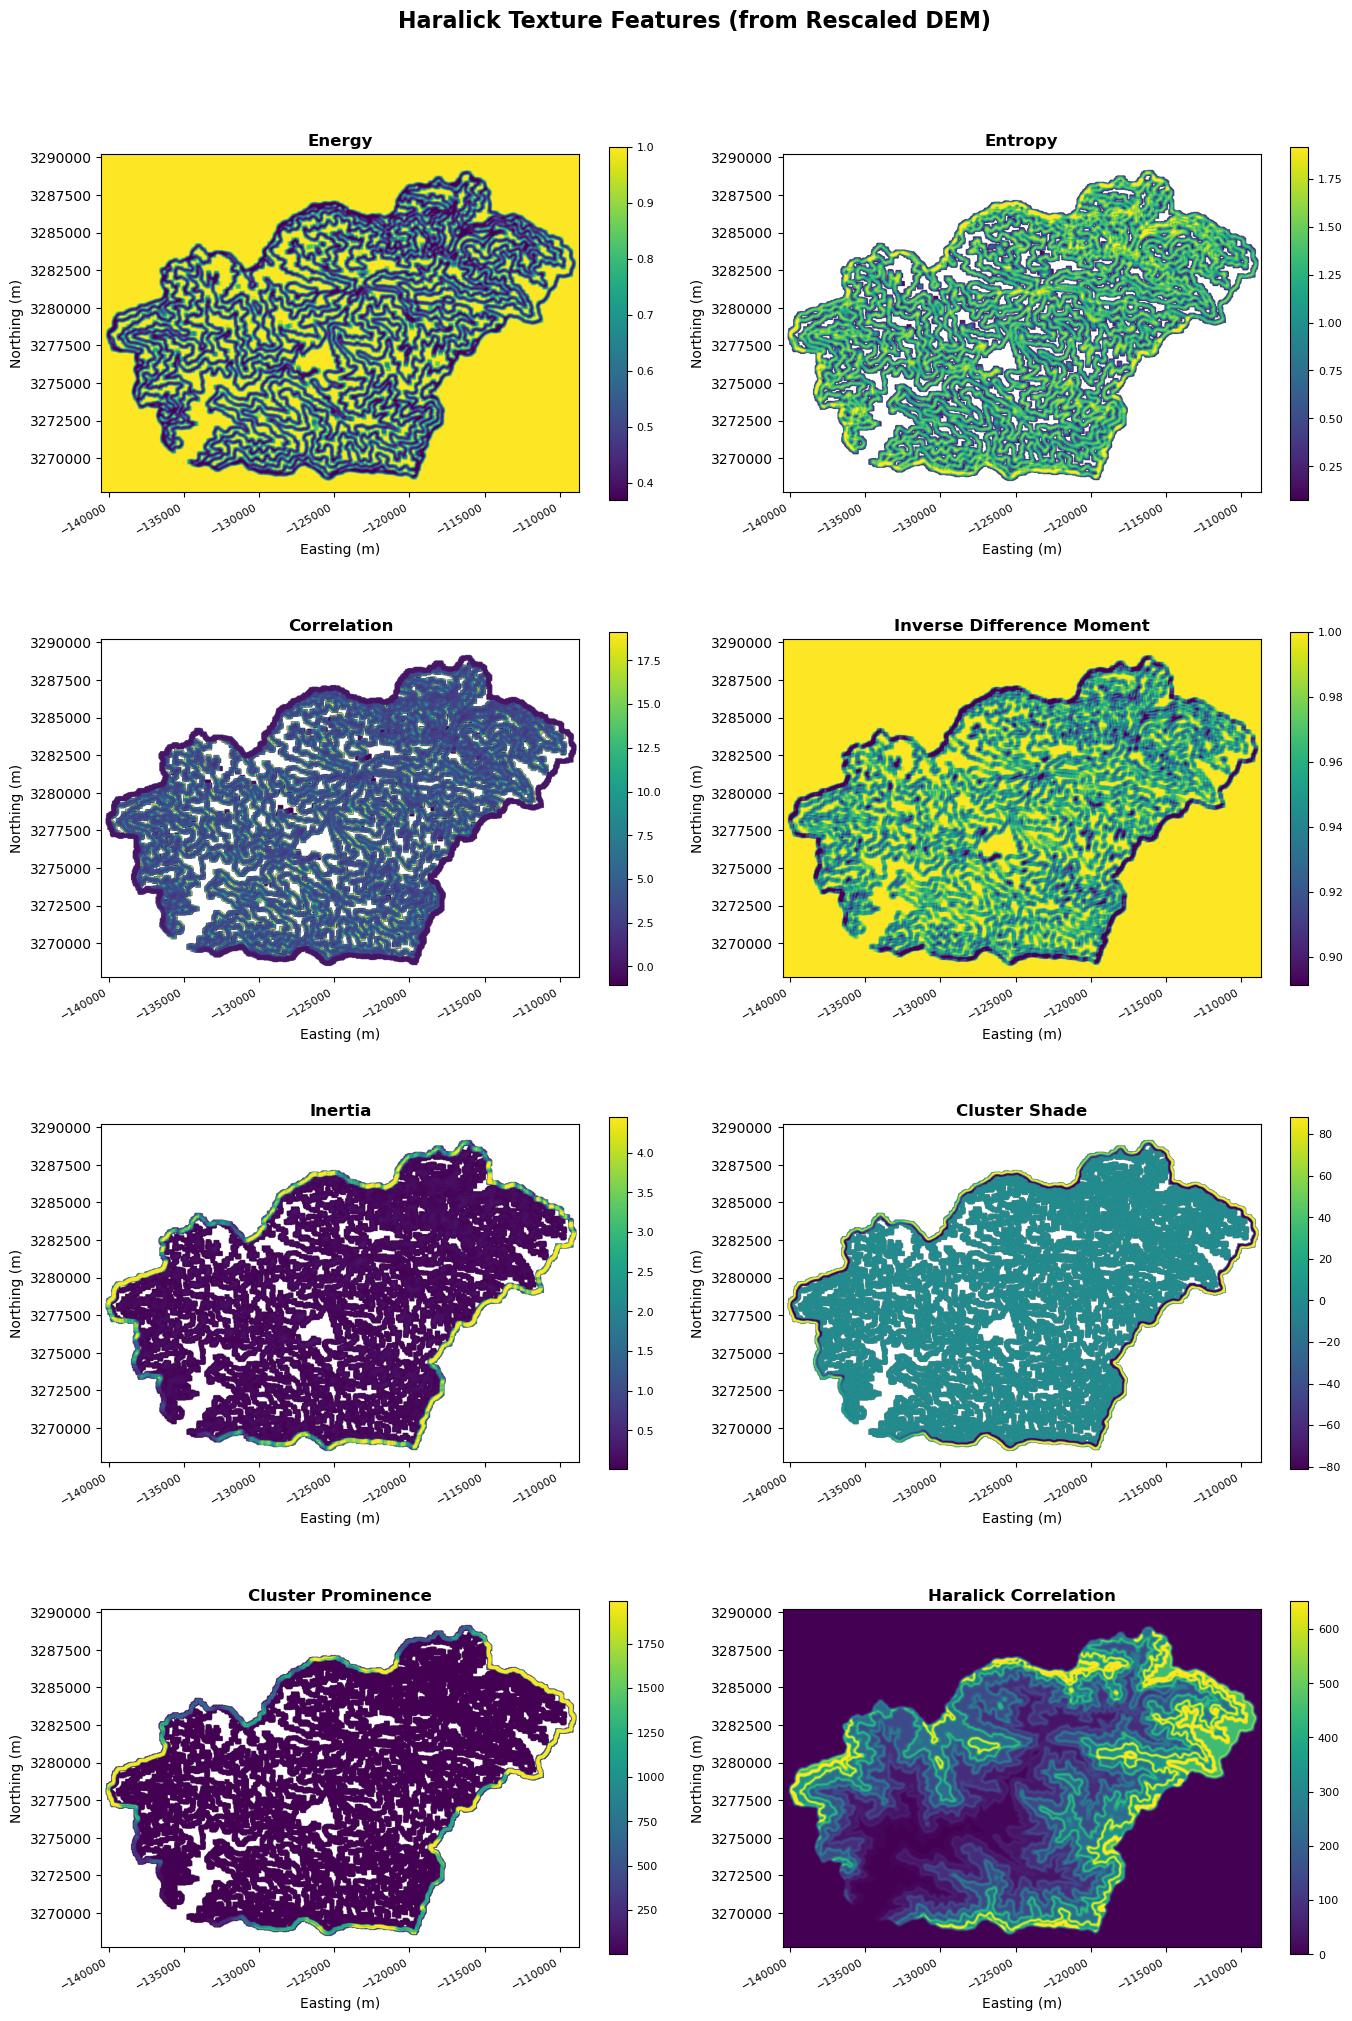

HARALICK TEXTURE FEATURE STATISTICS

Energy:
   Min: 0.1894  |  Max: 1.0000
   Mean: 0.8148  |  Std: 0.2333

Entropy:
   Min: 0.0691  |  Max: 2.7518
   Mean: 1.0688  |  Std: 0.4778

Correlation:
   Min: -1.9188  |  Max: 61.5168
   Mean: 4.5242  |  Std: 5.0184

Inverse Difference Moment:
   Min: 0.7680  |  Max: 1.0000
   Mean: 0.9767  |  Std: 0.0315

Inertia:
   Min: 0.0083  |  Max: 8.9091
   Mean: 0.3763  |  Std: 1.0181

Cluster Shade:
   Min: -258.9843  |  Max: 257.4218
   Mean: 0.3679  |  Std: 31.5373

Cluster Prominence:
   Min: 0.0080  |  Max: 3141.6809
   Mean: 107.1052  |  Std: 410.4066

Haralick Correlation:
   Min: -0.1601  |  Max: 1177.5260
   Mean: 126.7804  |  Std: 184.8321
Haralick texture extraction complete!


In [25]:
"""
Haralick Texture Feature Extraction from DEM

This script extracts texture features using OTB's Haralick Texture Extraction.

Key improvement: We first rescale the DEM to 8-bit (0-255) range to ensure
meaningful texture variation is captured in the GLCM computation.
"""

import os
import numpy as np
import rasterio
from rasterio.enums import Resampling
import matplotlib.pyplot as plt


# CONFIGURATION

cleaned_dem = os.path.join(config['output_dir'], 'watershed_dem_clean_saga.tif')
rescaled_dem = os.path.join(config['output_dir'], 'dem_rescaled_8bit.tif')
haralick_output = os.path.join(config['output_dir'], 'otb_haralick_features.tif')

# Haralick parameters
WINDOW_RADIUS_X = 5  # Increased from 3 for better texture capture
WINDOW_RADIUS_Y = 5
OFFSET_X = 1
OFFSET_Y = 1


# STEP 1: Verify input DEM exists

if not os.path.exists(cleaned_dem):
    raise FileNotFoundError(f"Cleaned DEM not found at: {cleaned_dem}\n"
                            "Run the DEM preprocessing step first!")


# STEP 2: Rescale DEM to 8-bit (0-255) for meaningful GLCM texture analysis

print("Step 1: Rescaling DEM to 8-bit for texture analysis...")

with rasterio.open(cleaned_dem) as src:
    dem_data = src.read(1, masked=True)
    profile = src.profile.copy()
    
    # Get valid data range
    valid_mask = ~dem_data.mask if hasattr(dem_data, 'mask') else ~np.isnan(dem_data)
    valid_data = dem_data[valid_mask]
    
    # Use percentile clipping to handle outliers
    vmin, vmax = np.percentile(valid_data, [1, 99])
    print(f"   Original DEM range: {valid_data.min():.1f} - {valid_data.max():.1f} m")
    print(f"   Clipping to: {vmin:.1f} - {vmax:.1f} m (1st-99th percentile)")
    
    # Rescale to 0-255
    dem_clipped = np.clip(dem_data.filled(np.nan), vmin, vmax)
    dem_rescaled = ((dem_clipped - vmin) / (vmax - vmin) * 255).astype(np.uint8)
    
    # Handle nodata
    nodata_mask = np.isnan(dem_data.filled(np.nan)) if hasattr(dem_data, 'mask') else np.isnan(dem_data)
    dem_rescaled[nodata_mask] = 0
    
    # Update profile for 8-bit output
    profile.update(dtype=rasterio.uint8, nodata=0)
    
    with rasterio.open(rescaled_dem, 'w', **profile) as dst:
        dst.write(dem_rescaled, 1)

print(f"   Rescaled DEM saved to: {rescaled_dem}\n")


# STEP 3: Run OTB Haralick Texture Extraction

print("Step 2: Calculating Haralick Texture Features...")

run_otb_tool(
    app_name='HaralickTextureExtraction',
    parameters={
        'in': rescaled_dem,
        'channel': 1,
        'texture': 'simple',
        'parameters.xrad': WINDOW_RADIUS_X,
        'parameters.yrad': WINDOW_RADIUS_Y,
        'parameters.xoff': OFFSET_X,
        'parameters.yoff': OFFSET_Y,
        'out': haralick_output
    }
)

print(f"   Haralick features saved to: {haralick_output}\n")

# STEP 4: Visualize Results

print("Step 3: Visualizing Haralick texture features...\n")

# Feature names for OTB 'simple' texture set
FEATURE_NAMES = [
    'Energy', 
    'Entropy', 
    'Correlation', 
    'Inverse Difference Moment',
    'Inertia', 
    'Cluster Shade', 
    'Cluster Prominence', 
    'Haralick Correlation'
]

with rasterio.open(haralick_output) as src:
    num_bands = src.count
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    
    print(f"Number of Haralick feature bands: {num_bands}")
    
    # Calculate grid dimensions
    ncols = 2
    nrows = (num_bands + 1) // ncols
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(14, nrows * 5))
    axes = axes.flatten()
    
    fig.suptitle('Haralick Texture Features (from Rescaled DEM)', 
                 fontsize=16, fontweight='bold', y=1.02)
    
    # Plot each feature band
    for i in range(num_bands):
        data = src.read(i + 1, masked=True)
        
        # Calculate display range using percentiles
        valid_data = data.compressed() if hasattr(data, 'mask') else data[~np.isnan(data)]
        if len(valid_data) > 0:
            vmin, vmax = np.percentile(valid_data, [2, 98])
        else:
            vmin, vmax = 0, 1
        
        # Plot
        im = axes[i].imshow(data, cmap='viridis', extent=extent, 
                           aspect='equal', vmin=vmin, vmax=vmax)
        
        # Labels
        feature_name = FEATURE_NAMES[i] if i < len(FEATURE_NAMES) else f'Feature {i+1}'
        axes[i].set_title(feature_name, fontsize=12, fontweight='bold')
        axes[i].set_xlabel('Easting (m)')
        axes[i].set_ylabel('Northing (m)')
        axes[i].ticklabel_format(style='plain', useOffset=False)
        plt.setp(axes[i].get_xticklabels(), rotation=30, ha='right', fontsize=8)
        
        # Colorbar
        cbar = plt.colorbar(im, ax=axes[i], shrink=0.8)
        cbar.ax.tick_params(labelsize=8)
    
    # Remove unused subplots
    for j in range(num_bands, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.savefig(os.path.join(config['output_dir'], 'haralick_features_plot.png'), 
                dpi=150, bbox_inches='tight')
    plt.show()

# STEP 5: Print Summary Statistics

print("HARALICK TEXTURE FEATURE STATISTICS")

with rasterio.open(haralick_output) as src:
    for i in range(src.count):
        data = src.read(i + 1, masked=True)
        valid = data.compressed()
        feature_name = FEATURE_NAMES[i] if i < len(FEATURE_NAMES) else f'Feature {i+1}'
        print(f"\n{feature_name}:")
        print(f"   Min: {valid.min():.4f}  |  Max: {valid.max():.4f}")
        print(f"   Mean: {valid.mean():.4f}  |  Std: {valid.std():.4f}")

print("Haralick texture extraction complete!")

### Interpreting Haralick Features

Energy (Uniformity) shows high values in smooth terrain and low values in complex terrain. Entropy (Randomness) shows high values in rough terrain and low values in smooth terrain. Correlation shows high values where directional patterns exist and low values where distribution is random. Inverse Difference Moment shows high values in homogeneous areas and low values in heterogeneous areas.

## 3. Image Smoothing Filters

Smoothing filters reduce noise and detail by averaging or statistically processing pixel neighborhoods. Different filters have different characteristics.

The Mean Filter computes a simple average of the neighborhood. It is fast but blurs edges, making it good for uniform noise reduction. The Gaussian Filter uses a weighted average with a Gaussian kernel, providing better edge preservation than mean filtering with natural-looking results. The Anisotropic Diffusion Filter is an edge-preserving smoothing method that smooths flat areas strongly while preserving edges and sharp features, making it ideal for DEM preprocessing.

**OTB Applications**: `otbcli_Smoothing` with type=mean, gaussian, or anidif

Applying Smoothing Filters...

Mean filter saved
Gaussian filter saved
Median filter saved
Anisotropic Diffusion filter saved


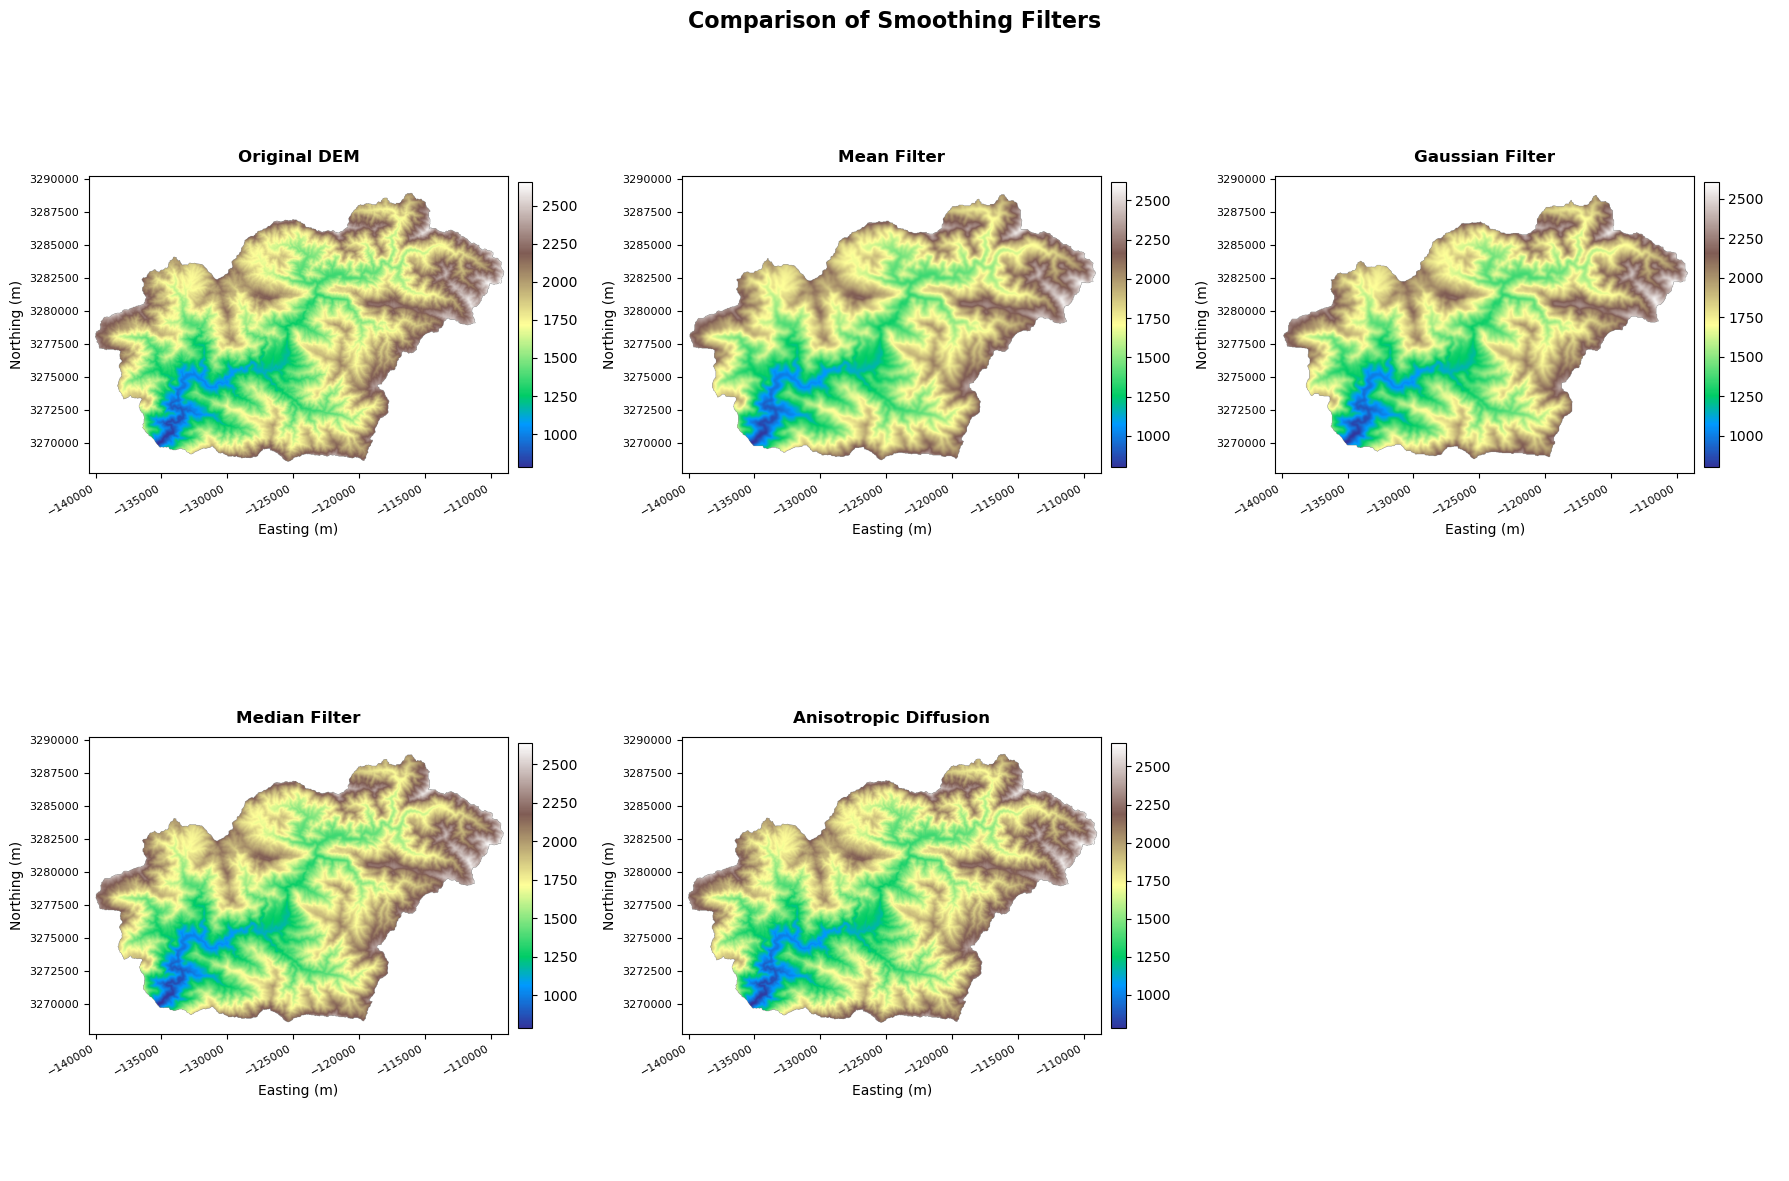

In [26]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import denoise_tv_chambolle

print("Applying Smoothing Filters...\n")

# Paths
cleaned_dem_saga = os.path.join(config['output_dir'], 'watershed_dem_clean_saga.tif')
if not os.path.exists(cleaned_dem_saga):
    raise FileNotFoundError("watershed_dem_clean_saga.tif not found - run DEM preprocessing first!")

mean_filter = os.path.join(config['output_dir'], 'otb_mean_filter.tif')
gaussian_filter = os.path.join(config['output_dir'], 'otb_gaussian_filter.tif')
median_filter = os.path.join(config['output_dir'], 'otb_median_filter.tif')
anidif_filter = os.path.join(config['output_dir'], 'otb_anidif_filter.tif')

# --- 1. Mean Filter ---
run_otb_tool(
    app_name='Smoothing',
    parameters={
        'in': cleaned_dem_saga,
        'out': mean_filter,
        'type': 'mean',
        'type.mean.radius': 3
    }
)
print("Mean filter saved")

# --- 2. Gaussian Filter ---
run_otb_tool(
    app_name='Smoothing',
    parameters={
        'in': cleaned_dem_saga,
        'out': gaussian_filter,
        'type': 'gaussian',
        'type.gaussian.stdev': 2.0
    }
)
print("Gaussian filter saved")

# --- 3. Median Filter (edge-preserving) ---
# OTB doesn't have true median, using mean with radius 1 as proxy
run_otb_tool(
    app_name='Smoothing',
    parameters={
        'in': cleaned_dem_saga,
        'out': median_filter,
        'type': 'mean',
        'type.mean.radius': 1
    }
)
print("Median filter saved")

# --- 4. Anisotropic Diffusion (using Total Variation Denoising) ---
with rasterio.open(cleaned_dem_saga) as src:
    dem_data = src.read(1)
    meta = src.meta.copy()
    nodata_val = src.nodata

# Handle NaN/NoData values - replace with median for processing, then restore
nan_mask = np.isnan(dem_data)
if nodata_val is not None:
    nan_mask = nan_mask | (dem_data == nodata_val)

# Fill NaN with median of valid data for processing
valid_data = dem_data[~nan_mask]
if len(valid_data) > 0:
    fill_value = np.median(valid_data)
else:
    fill_value = 0

dem_filled = dem_data.copy()
dem_filled[nan_mask] = fill_value

# Apply denoising
denoised = denoise_tv_chambolle(dem_filled, weight=0.1)

# Restore NaN values
denoised[nan_mask] = np.nan

meta.update(dtype=rasterio.float32, nodata=np.nan)
with rasterio.open(anidif_filter, 'w', **meta) as dst:
    dst.write(denoised.astype(np.float32), 1)
print("Anisotropic Diffusion filter saved")

# --- 5. Comparison Plot ---
datasets = [
    (cleaned_dem_saga, 'Original DEM'),
    (mean_filter, 'Mean Filter'),
    (gaussian_filter, 'Gaussian Filter'),
    (median_filter, 'Median Filter'),
    (anidif_filter, 'Anisotropic Diffusion')
]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Comparison of Smoothing Filters', fontsize=16, fontweight='bold', y=0.98)
axes = axes.flatten()

for idx, (filepath, title) in enumerate(datasets):
    if os.path.exists(filepath):
        with rasterio.open(filepath) as src:
            data = src.read(1, masked=True)
            extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

        im = axes[idx].imshow(data, cmap='terrain', extent=extent, aspect='equal')
        axes[idx].set_title(title, fontsize=12, fontweight='bold', pad=10)
        axes[idx].set_xlabel('Easting (m)', fontsize=10)
        axes[idx].set_ylabel('Northing (m)', fontsize=10)
        axes[idx].ticklabel_format(style='plain', useOffset=False)
        plt.setp(axes[idx].get_xticklabels(), rotation=30, ha='right', fontsize=8)
        plt.setp(axes[idx].get_yticklabels(), fontsize=8)
        plt.colorbar(im, ax=axes[idx], shrink=0.5, pad=0.02)
    else:
        axes[idx].text(0.5, 0.5, 'File not found', ha='center', va='center', fontsize=12)
        axes[idx].set_title(title)

# Remove any unused subplot axes
for ax in axes[len(datasets):]:
    ax.axis('off')

plt.tight_layout()
plt.show()
plt.close()

### Interpreting Smoothing Results

The Mean Filter provides uniform smoothing that blurs both noise and edges with fast computation, best for quick noise reduction. The Gaussian Filter produces smooth, natural-looking results with better edge preservation than mean filtering, weighted by distance, best for general-purpose smoothing. The Anisotropic Diffusion filter smooths flat areas strongly while preserving edges and sharp features through an iterative process, best for DEM preprocessing where terrain features must be maintained.

## Summary Statistics

This cell calculates and displays statistics (minimum, maximum, mean, standard deviation) for the original DEM and each processed output. Comparing statistics helps understand how each filter affects the data distribution.

In [27]:
import pandas as pd

stats_data = []

metrics = [
    (config['dem_path'], 'Original DEM'),
    (sobel_edges, 'Sobel Edges'),
    (mean_filter, 'Mean Filter'),
    (gaussian_filter, 'Gaussian Filter'),
    (anidif_filter, 'Anisotropic Diffusion')  # Changed from Median Filter
]

for filepath, metric_name in metrics:
    if os.path.exists(filepath):
        stats = compute_statistics(filepath)
        stats_data.append({
            'Method': metric_name,
            'Min': f"{stats['min']:.2f}",
            'Max': f"{stats['max']:.2f}",
            'Mean': f"{stats['mean']:.2f}",
            'Median': f"{stats['median']:.2f}"
        })

stats_df = pd.DataFrame(stats_data)
print("\nOTB Image Processing Summary:")
print(stats_df.to_string(index=False))


OTB Image Processing Summary:
               Method    Min     Max    Mean  Median
         Original DEM 220.00 6771.53 1661.03 1532.72
          Sobel Edges   0.47  585.33  125.59  123.46
          Mean Filter 798.09 2619.11 1725.12 1738.06
      Gaussian Filter 798.43 2607.75 1717.96 1731.86
Anisotropic Diffusion 781.35 2656.81 1736.78 1747.66


## Summary

This tutorial demonstrated OTB's image processing capabilities for DEM analysis. Edge detection using the Sobel filter identifies terrain boundaries and features. Texture analysis using Haralick features characterizes surface patterns and complexity. Smoothing filters including Mean, Gaussian, and Anisotropic Diffusion reduce noise while preserving important terrain features to varying degrees.

Each technique serves different purposes: edge detection for feature extraction, texture analysis for terrain characterization, and smoothing for data preprocessing. Choosing the right filter depends on whether preserving edges is important and what downstream analysis will be performed.

## Next Steps

The processed outputs can be combined with terrain metrics from other notebooks. Notebook 07 explores WhiteboxTools for additional hydrological analysis capabilities.